In [ ]:
# Install MNE library (if not already installed)
!pip install mne
# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
mat_data = scipy.io.loadmat(file_path)
raw_signal = mat_data['Signal']
raw_signal_v = raw_signal * 1e-6
n_epochs, n_samples, n_channels = raw_signal_v.shape
eeg_reshaped = raw_signal_v.transpose(2, 0, 1).reshape(n_channels, -1)

flashing = mat_data['Flashing']
stimulus_code = mat_data['StimulusCode']
stimulus_type = mat_data['StimulusType']

flashing_flat = flashing.flatten()
stimulus_code_flat = stimulus_code.flatten()
stimulus_type_flat = stimulus_type.flatten()
eeg_length = eeg_reshaped.shape[1] # Corrected: Use shape[1] for total samples, as shape[0] is n_channels
print(f"EEG LENGTH: {eeg_length}")
print(f"MARKER1 LENGTH: {len(flashing_flat)}") # Corrected: Print length of flashing_flat
if len(flashing_flat) == eeg_length:
  print("Lengths are consistent!")
else:
  print("Lengths are NOT consistent!")

flashing_diff = np.diff(flashing_flat, prepend = 0) # Corrected: 'prepand' to 'prepend'
onset_indices = np.where(flashing_diff == 1)[0]
event_ids =  stimulus_code_flat[onset_indices].astype(int)
events = np.column_stack((onset_indices, np.zeros_like(onset_indices), event_ids))

sampling_freq = 240.0
ch_names = [f'EEG_{i:03d}' for i in range(n_channels)]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names = ch_names, sfreq = sampling_freq, ch_types = ch_types)
raw = mne.io.RawArray(eeg_reshaped, info)
stim_info = mne.create_info(['STI 014'], sampling_freq, ['stim'])
stim_raw = mne.io.RawArray(np.zeros((1, eeg_reshaped.shape[1])), stim_info)
raw.add_channels([stim_raw])
raw.add_events(events, stim_channel='STI 014')

# 1. Mount Google Drive
# Mount Google Drive to access the dataset.
# (Example: drive.mount('/content/drive'))

# 2. Load the Data
# Load the '.mat' file using scipy.io.loadmat.
# (Example: file_path = '/content/drive/My Drive/eea/Dataset/Subject_A_Train.mat'; mat_data = scipy.io.loadmat(file_path))

# 3. Extract & Reshape EEG Signal
# The raw signal is typically 3D (Epochs, Samples, Channels).
# Reshape it into 2D (Channels, Total_Samples) for MNE.
# This involves concatenating epochs and transposing the data.
# Convert the units from microvolts (uV) to Volts (V).

# 4. Process Marker Channels (e.g., Flashing & StimulusCode)
# These markers are usually 3D or 2D and need to be flattened to 1D to match the continuous signal length.
# Ensure the lengths of the processed signal and markers are consistent.

# 5. Construct MNE Events
# Using the processed marker channels (e.g., 'Flashing' for onset detection and 'StimulusCode' for event IDs),
# detect event onsets (e.g., rising edges of the 'Flashing' signal).
# Then, create an MNE-compatible events array: (onset_index, 0, event_id).

# 6. Create MNE Raw Object
# Define the sampling frequency (sfreq), channel names (ch_names), and channel types (ch_types).
# Then, create an MNE 'info' object.
# Finally, create an 'mne.io.RawArray' object from the reshaped EEG signal and the 'info' object.
# Optionally, add the events as a 'stim' channel to the raw object.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EEG LENGTH: 662490
MARKER1 LENGTH: 662490
Lengths are consistent!
Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-524262512.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)

Effective window size : 8.533 (s)
Finding events on: STI 014
Trigger channel STI 014 has a non-zero initial value of 12 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15299 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Finding events on: STI 014
Trigger channel STI 014 has a non-zero initial value of 12 (consider using initial_ev

/tmp/ipython-input-524262512.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd_after.plot()


Plotting power spectral density (dB=True).


/tmp/ipython-input-524262512.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd_filtered.plot()


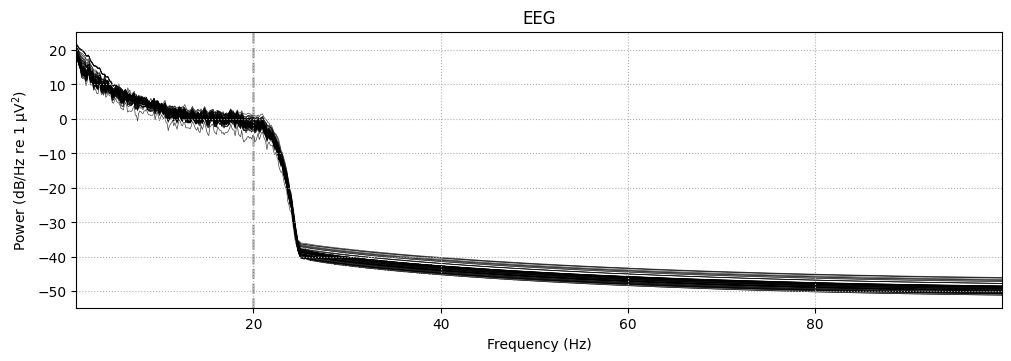

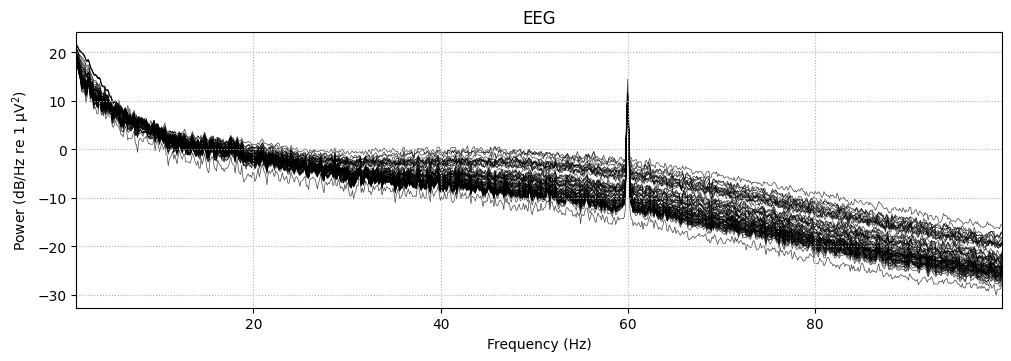

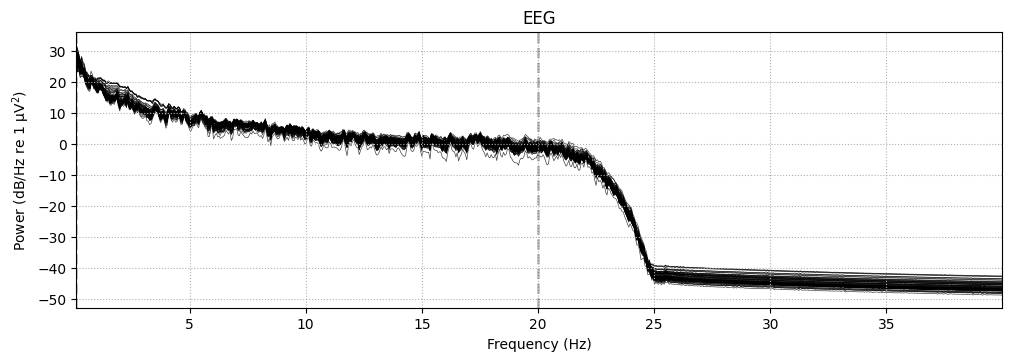

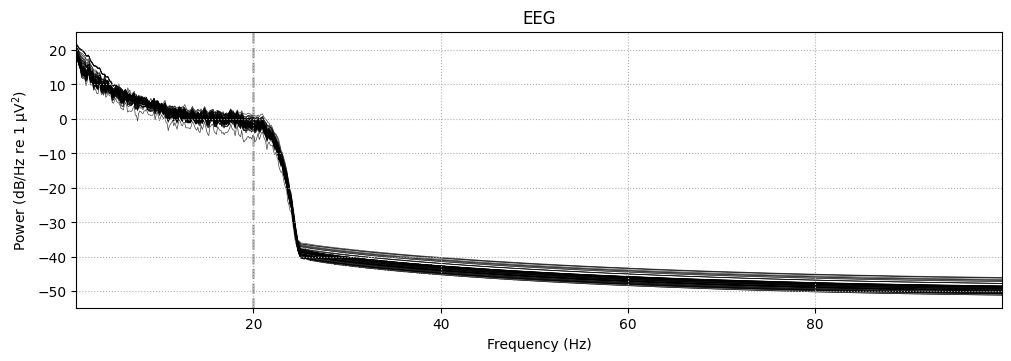

In [ ]:
psd = raw.compute_psd(fmin=1, fmax=100)
psd.plot()
raw_filtered = raw.copy().filter(l_freq=0.1, h_freq=20.0, fir_design='firwin')
psd_filtered = raw_filtered.compute_psd(fmin=1, fmax=100)
raw_resampled = raw_filtered.copy().resample(sfreq=120.0)
psd_after = raw_resampled.compute_psd(fmin=0.1, fmax=40)
psd_after.plot()
psd_filtered.plot()

## https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#

# 1. Visualize Data BEFORE Filtering (Power Spectral Density)
# Compute and plot the Power Spectral Density (PSD) of the raw data
# to observe the frequency content before any filtering (e.g., raw.compute_psd().plot()).

# 2. Apply Band-pass Filter
# Apply a band-pass filter to the raw data (e.g., 0.1Hz - 20Hz) to remove unwanted frequencies.
# Consider using an FIR filter design (e.g., raw.filter(l_freq=..., h_freq=..., fir_design='firwin')).

# 3. Downsample the Data
# Downsample the data to a lower sampling rate (e.g., from 240Hz to 120Hz).
# MNE's resample function automatically handles anti-aliasing (e.g., raw.resample(sfreq=...)).

# 4. Visualize Data AFTER Filtering
# Compute and plot the PSD of the filtered and downsampled data
# to verify the effectiveness of the filtering (e.g., raw.compute_psd().plot()).



In [42]:
from mne.preprocessing import ICA
ica = ICA(n_components=20, random_state=97)
ica.fit(raw_resampled)
mapping = {raw.ch_names[i]: ch_names[i] for i in range(len(ch_names))}
raw.rename_channels(mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.plot_sensors(show_names=True)
ica.plot_components()



# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#
# 1. Assign Standard Channel Names and Montage
# The initial channel names might be generic (e.g., EEG_1, EEG_2).
# Rename the EEG channels to standard names (e.g., 'FC5', 'Cz', 'Pz')
# that correspond to a known montage (e.g., 'standard_1005' or 'standard_1020').
# This is crucial for visualizing components topologically.
# Then, set a standard montage using mne.channels.make_standard_montage.

# 2. Initialize and Fit ICA
# Initialize an ICA object (e.g., mne.preprocessing.ICA) specifying parameters like n_components and random_state.
# Then, fit the ICA model to the raw data, often applying a high-pass filter (>1Hz) for better component separation.
# (Example: ica.fit(raw, reject=dict(eeg=...)))

# 3. Plot ICA Components
# After fitting, plot the ICA components to visually inspect them for artifacts like eye blinks or muscle activity.
# (Example: ica.plot_components())

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 50.5s.


ValueError: DigMontage is only a subset of info. There are 64 channel positions not present in the DigMontage. The channels missing from the montage are:

['EEG_000', 'EEG_001', 'EEG_002', 'EEG_003', 'EEG_004', 'EEG_005', 'EEG_006', 'EEG_007', 'EEG_008', 'EEG_009', 'EEG_010', 'EEG_011', 'EEG_012', 'EEG_013', 'EEG_014', 'EEG_015', 'EEG_016', 'EEG_017', 'EEG_018', 'EEG_019', 'EEG_020', 'EEG_021', 'EEG_022', 'EEG_023', 'EEG_024', 'EEG_025', 'EEG_026', 'EEG_027', 'EEG_028', 'EEG_029', 'EEG_030', 'EEG_031', 'EEG_032', 'EEG_033', 'EEG_034', 'EEG_035', 'EEG_036', 'EEG_037', 'EEG_038', 'EEG_039', 'EEG_040', 'EEG_041', 'EEG_042', 'EEG_043', 'EEG_044', 'EEG_045', 'EEG_046', 'EEG_047', 'EEG_048', 'EEG_049', 'EEG_050', 'EEG_051', 'EEG_052', 'EEG_053', 'EEG_054', 'EEG_055', 'EEG_056', 'EEG_057', 'EEG_058', 'EEG_059', 'EEG_060', 'EEG_061', 'EEG_062', 'EEG_063'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

Creating RawArray with float64 data, n_channels=20, n_times=331245
    Range : 0 ... 331244 =      0.000 ...  2760.367 secs
Ready.
Using matplotlib as 2D backend.


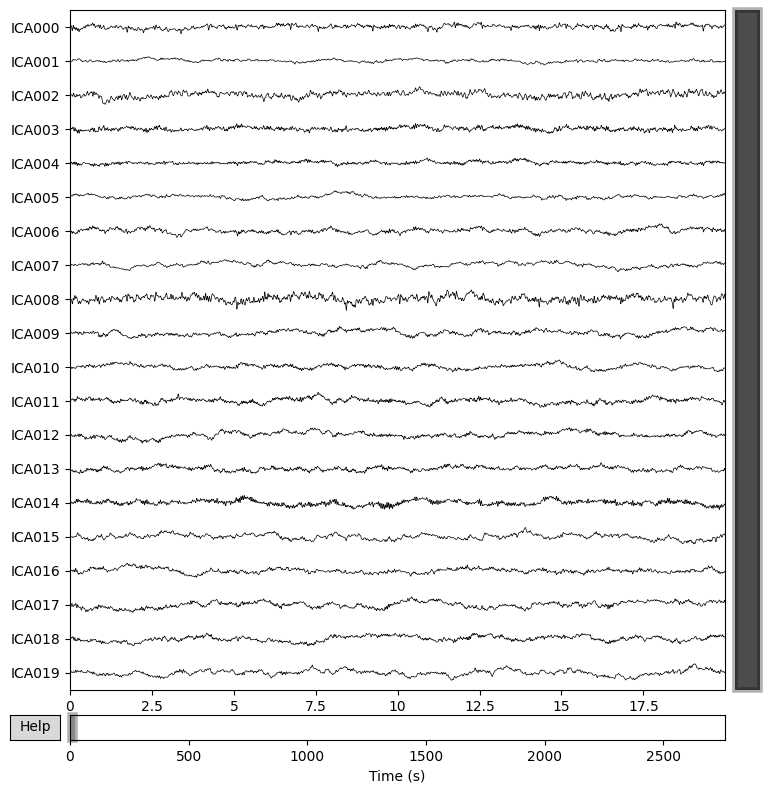

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


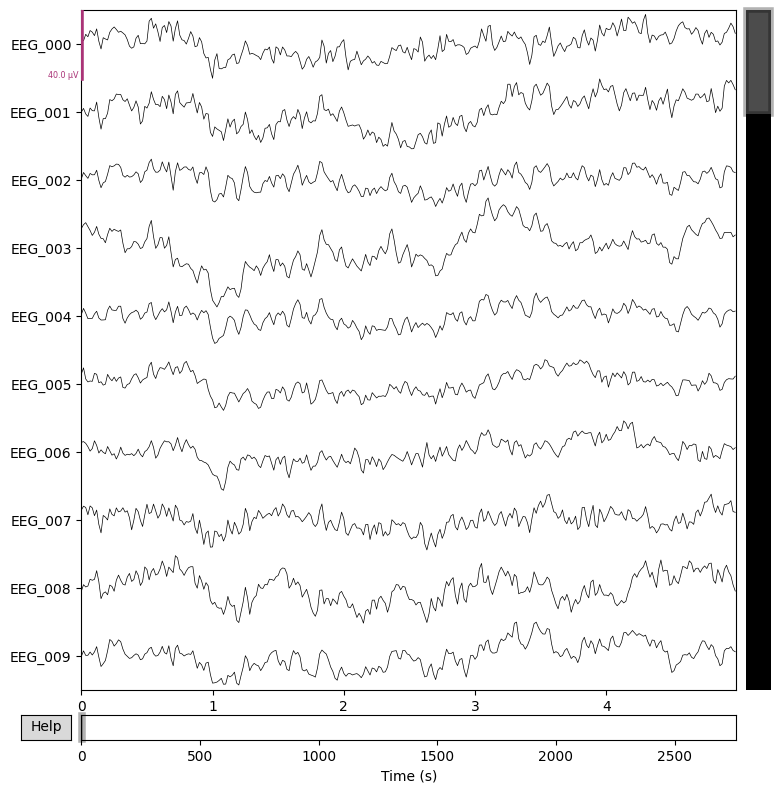

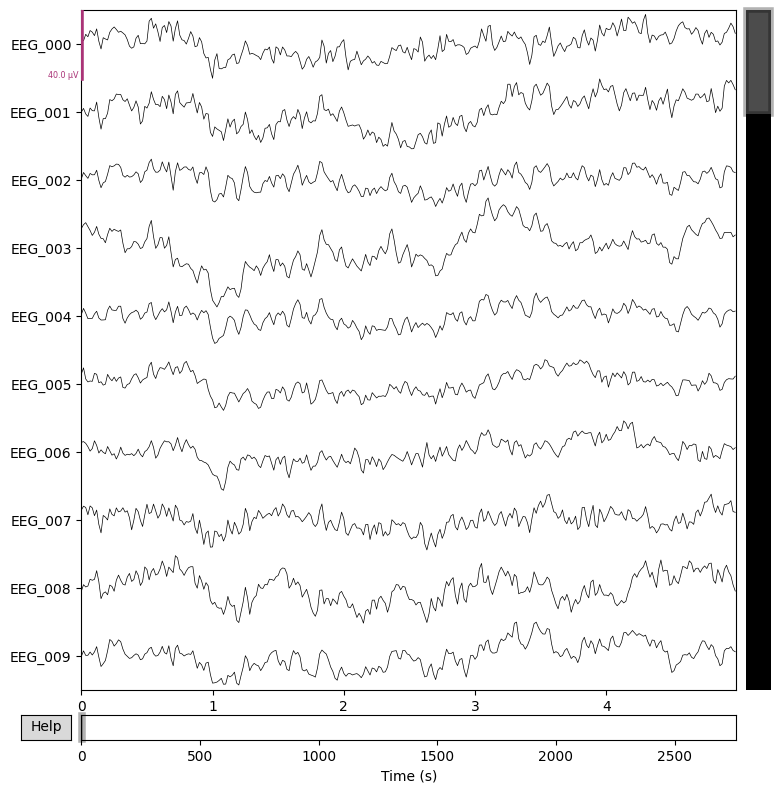

In [41]:

ica.plot_sources(raw_resampled)
ica.exclude = [0,5]
raw_ica = raw_resampled.copy()
ica.apply(raw_ica)
raw_ica.plot(n_channels=10, duration=5, title='Data AFTER ICA')
# 1. Identify and Exclude Artifact Components
# Based on visual inspection of the ICA components (from the previous step),
# identify components that clearly represent artifacts (e.g., eye blinks, eye movements, muscle activity).
# Then, set the 'exclude' attribute of the ICA object with the indices of these artifact components.

# 2. Apply ICA to Remove Artifacts
# Apply the trained ICA model with the excluded components to the raw data.
# This will project the data back into sensor space with the identified artifact components removed.
# (Example: ica.apply(raw))

# 3. Visualize Clean Data
# To verify the artifact removal, plot a segment of the cleaned raw data.
# Observe if the previously identified artifacts (like large eye blinks) have been successfully suppressed.
# (Example: raw.plot(n_channels=..., duration=..., title='Data AFTER removing Blinks'))


Not setting metadata
15300 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15300 events and 217 original time points ...
1 bad epochs dropped
<Epochs | 15299 events (all good), -0.1 – 0.8 s (baseline -0.1 – 0 s), ~1.61 GiB, data loaded,
 'Non-Target': 12749
 'Target': 2550>


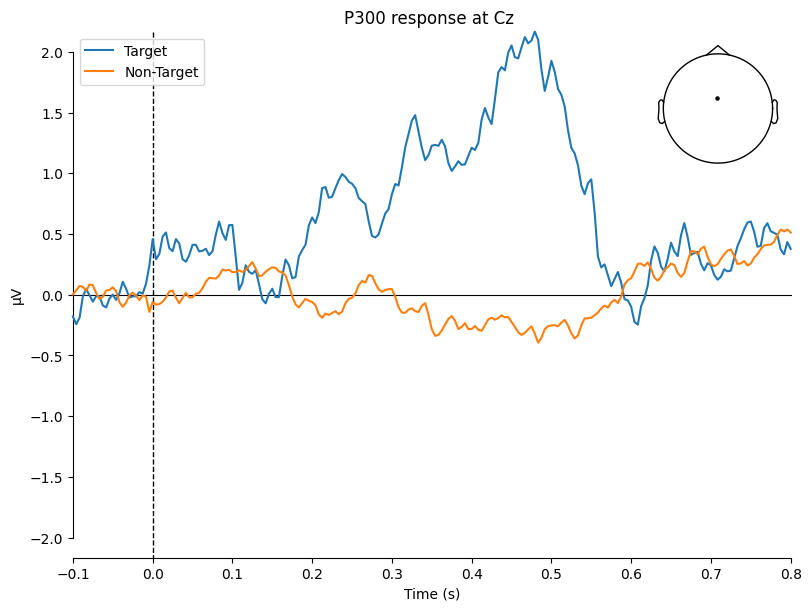

[<Figure size 800x600 with 2 Axes>]

In [38]:
target_labels = stimulus_type_flat[onset_indices].astype(int)
event_ids_labeled = target_labels + 1
events_1 = np.column_stack((onset_indices, np.zeros_like(onset_indices), event_ids_labeled))
event_id_dict = {'Non-Target': 1, 'Target': 2}
epochs = mne.Epochs(raw_ica, events_1, event_id = event_id_dict, tmin=-0.1 , tmax = 0.8, baseline = (None, 0), preload = True)
print(epochs)
evoked_target = epochs['Target'].average()
evoked_non_target = epochs['Non-Target'].average()
mne.viz.plot_compare_evokeds({'Target': evoked_target, 'Non-Target': evoked_non_target},picks = 'Cz', title = 'P300 response at Cz ', show_sensors = 'upper right')

# 1. Prepare Events for Epoching
# Load and process the 'StimulusType' data to assign labels (e.g., Target/Non-Target)
# to the event onsets identified earlier. Create a new MNE-compatible events array
# where the third column represents the event ID (e.g., 1 for Non-Target, 2 for Target).
# Ensure the event IDs are integers.

# 2. Define Event IDs Dictionary
# Create a dictionary mapping descriptive event names (e.g., 'Non-Target', 'Target') to their corresponding integer IDs.

# 3. Create Epochs
# Use mne.Epochs to segment the continuous raw data around the events.
# Define the epoch time window (e.g., tmin, tmax), set a baseline correction,
# and preload the data into memory.

# 4. Compute Evoked Responses
# Compute the average evoked potentials for each event type (e.g., 'Target' and 'Non-Target')
# using the epochs object.

# 5. Visualize the P300 Response
# Plot the averaged evoked responses, typically focusing on a central parietal electrode like 'Cz' or 'Pz',
# to look for the characteristic P300 component (a positive deflection around 300ms post-stimulus).
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Cz')



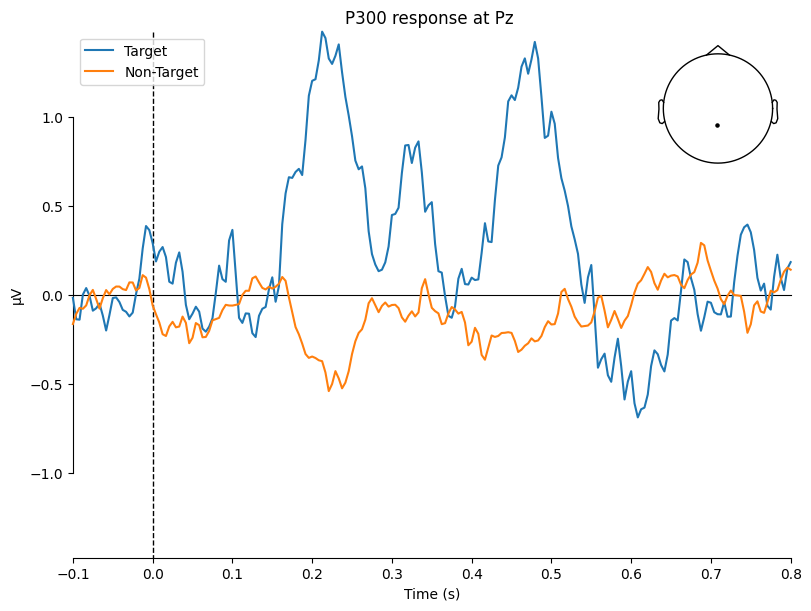

[<Figure size 800x600 with 2 Axes>]

In [40]:
mne.viz.plot_compare_evokeds({'Target': evoked_target, 'Non-Target': evoked_non_target},picks = 'Pz', title = 'P300 response at Pz ', show_sensors = 'upper right')
# 1. Compare Evokeds at Pz
# In addition to Cz, plot the evoked responses at channel 'Pz' (Parietal-central)
# as the P300 component is often prominently observed there.
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Pz')